In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sn
import pandas as pd

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

## Read Data

In [2]:
device = "cpu"

In [3]:
df = pd.read_csv('/data/data.csv', sep=";")
df.head()

,Player1,Player2,Player3,Player4,Eichel Ober,Eichel Unter,Eichel Ass,Eichel 10,Eichel König,Eichel 9,...,SchellenOber,SchellenUnter,SchellenAss,Schellen10,SchellenKönig,Schellen9,Schellen8,Schellen7,Modus,Win
0,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,1,1,0,0,weiter,-1
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,weiter,-1
2,0,0,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,Farbwenz Schelle,1
3,0,0,0,1,1,0,0,0,0,0,...,1,1,0,0,0,0,0,1,Farbgeier Schelle,1
4,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,1,weiter,1


## Transform Data
Remove the type weiter from Data, to only train the gametypes

In [34]:
df_filtered = df[df['Modus'] != 'weiter']
game_modes = df_filtered['Modus'].unique()
modus_counts_normalized = df_filtered['Modus'].value_counts(normalize=True)


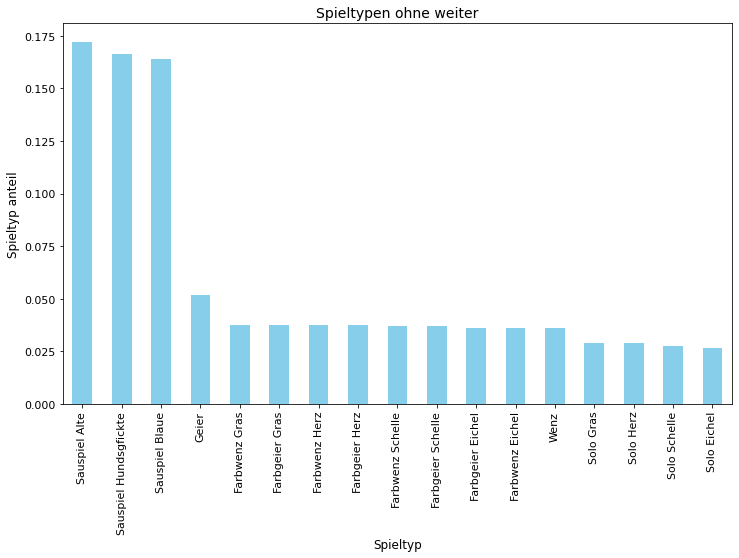

In [50]:
# Set the size of the figure
plt.figure(figsize=(12, 7))  # Width: 10 inches, Height: 6 inches

# Plotting the bar chart with a defined figure size
modus_counts_normalized.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title('Spieltypen ohne weiter', fontsize=14)
plt.xlabel('Spieltyp', fontsize=12)
plt.ylabel('Spieltyp anteil', fontsize=12)
plt.xticks(fontsize=11)  
plt.yticks(fontsize=11) 
# Display the plot
plt.show()

## Split train and test data

In [5]:
train_data = df_filtered.drop(['Player1','Player2','Player3','Player4','Win','Modus'], axis=1).astype("float32")
train_data.head()

,Eichel Ober,Eichel Unter,Eichel Ass,Eichel 10,Eichel König,Eichel 9,Eichel 8,Eichel 7,Gras Ober,Gras Unter,...,Herz 8,Herz 7,SchellenOber,SchellenUnter,SchellenAss,Schellen10,SchellenKönig,Schellen9,Schellen8,Schellen7
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
train_data_size = np.shape(np.array(train_data))
input_size = train_data_size[1]
print("Input Size: ", input_size)

Input Size:  32


In [7]:
output_data = df_filtered['Modus']
output_data_codes = output_data.astype("category").cat.codes
output_size = max(output_data_codes) + 1
y = output_data_codes.astype("long")
print("Output Size: ", output_size)

Output Size:  17


In [51]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y, test_size=0.2, random_state=42)

In [9]:
class SelectGameDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor([self.X.iloc[idx]], device=device), torch.tensor(self.y.iloc[idx], device=device)

In [10]:
train_dataset = SelectGameDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [11]:
test_dataset = SelectGameDataset(X_val, y_val)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Define Model

In [12]:
class SelectGameNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [55]:
model = SelectGameNN().to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
criterion = nn.CrossEntropyLoss()

## Training

In [16]:
num_epochs = 300
print_freq = 250  

for epoch in range(num_epochs):
    running_loss = 0.0  
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()
        
        
        running_loss += loss.item()

        if (batch_idx + 1) % print_freq == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {running_loss / print_freq:.4f}")
            running_loss = 0.0  

Epoch [1/300] Batch [250/495] Loss: 2.1356
Epoch [2/300] Batch [250/495] Loss: 1.1544
Epoch [3/300] Batch [250/495] Loss: 0.9880
Epoch [4/300] Batch [250/495] Loss: 0.8728
Epoch [5/300] Batch [250/495] Loss: 0.8332
Epoch [6/300] Batch [250/495] Loss: 0.8015
Epoch [7/300] Batch [250/495] Loss: 0.7824
Epoch [8/300] Batch [250/495] Loss: 0.7697
Epoch [9/300] Batch [250/495] Loss: 0.7608
Epoch [10/300] Batch [250/495] Loss: 0.7539
Epoch [11/300] Batch [250/495] Loss: 0.7367
Epoch [12/300] Batch [250/495] Loss: 0.7299
Epoch [13/300] Batch [250/495] Loss: 0.7280
Epoch [14/300] Batch [250/495] Loss: 0.7182
Epoch [15/300] Batch [250/495] Loss: 0.7095
Epoch [16/300] Batch [250/495] Loss: 0.6949
Epoch [17/300] Batch [250/495] Loss: 0.6888
Epoch [18/300] Batch [250/495] Loss: 0.6866
Epoch [19/300] Batch [250/495] Loss: 0.6893
Epoch [20/300] Batch [250/495] Loss: 0.6840
Epoch [21/300] Batch [250/495] Loss: 0.6799
Epoch [22/300] Batch [250/495] Loss: 0.6816
Epoch [23/300] Batch [250/495] Loss: 0.67

In [3]:
torch.save(model.state_dict(),'game_classifier.pth')

## Evaluation

In [27]:
model_params_path = os.path.join(os.getcwd(), "model", "params.pth")
params = torch.load(model_params_path, map_location=torch.device(device))
model = SelectGameNN()
model.load_state_dict(params)

<All keys matched successfully>

In [52]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 69.48%


In [30]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

In [54]:
# map output categoies
category_mapping = output_data.astype("category").cat.categories.tolist()
print("category mapping: ", category_mapping)

category mapping:  ['Farbgeier Eichel', 'Farbgeier Gras', 'Farbgeier Herz', 'Farbgeier Schelle', 'Farbwenz Eichel', 'Farbwenz Gras', 'Farbwenz Herz', 'Farbwenz Schelle', 'Geier', 'Sauspiel Alte', 'Sauspiel Blaue', 'Sauspiel Hundsgfickte', 'Solo Eichel', 'Solo Gras', 'Solo Herz', 'Solo Schelle', 'Wenz']


### Confusion Matrix Evaluation

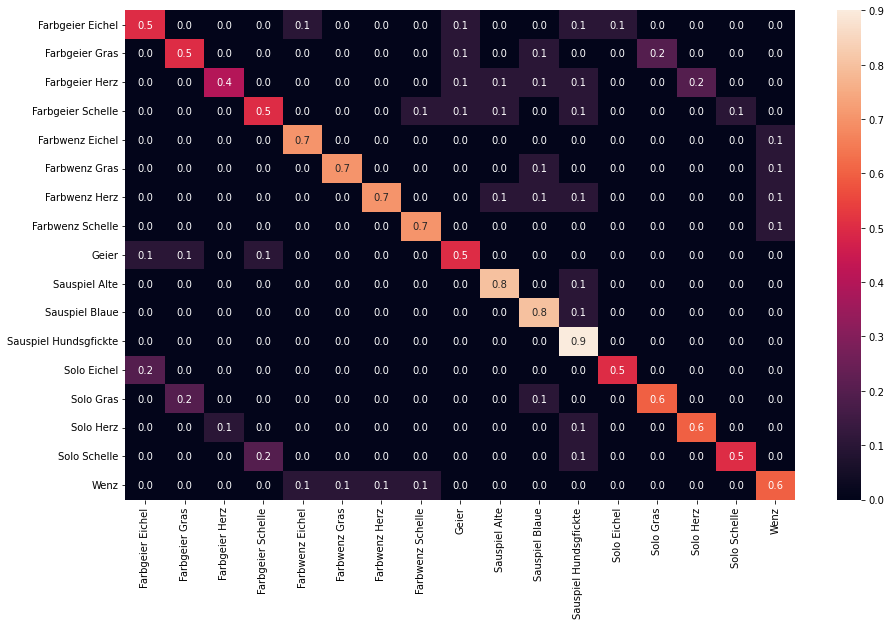

In [33]:
# your previous confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cf_matrix_norm = cf_matrix / np.sum(cf_matrix, axis=1)[:, np.newaxis]
cf_matrix_norm_rounded = np.round(cf_matrix_norm, decimals=1)  # round to 1 decimal

# Create DataFrame from the normalized and rounded confusion matrix
df_cm = pd.DataFrame(cf_matrix_norm_rounded, index=[i for i in category_mapping],
                     columns=[i for i in category_mapping])

# Create the heatmap with seaborn
plt.figure(figsize=(15, 9))
sn.heatmap(df_cm, annot=True, fmt='.1f')  # specify decimal format here for the annotation
plt.show()